Epoch 1/5
28/28 [==============================] - 42s 1s/step - loss: 0.8466 - accuracy: 0.6934 - val_loss: 0.7291 - val_accuracy: 0.5974
Epoch 2/5
28/28 [==============================] - 37s 1s/step - loss: 0.5087 - accuracy: 0.8057 - val_loss: 0.9792 - val_accuracy: 0.5087
Epoch 3/5
28/28 [==============================] - 37s 1s/step - loss: 0.4395 - accuracy: 0.8276 - val_loss: 1.0952 - val_accuracy: 0.5087
Epoch 4/5
28/28 [==============================] - 36s 1s/step - loss: 0.4096 - accuracy: 0.8332 - val_loss: 1.2604 - val_accuracy: 0.5087
Epoch 5/5
28/28 [==============================] - 37s 1s/step - loss: 0.3815 - accuracy: 0.8445 - val_loss: 1.3744 - val_accuracy: 0.5087
INFO:tensorflow:Assets written to: saved_models/gender_detection.model\assets


INFO:tensorflow:Assets written to: saved_models/gender_detection.model\assets


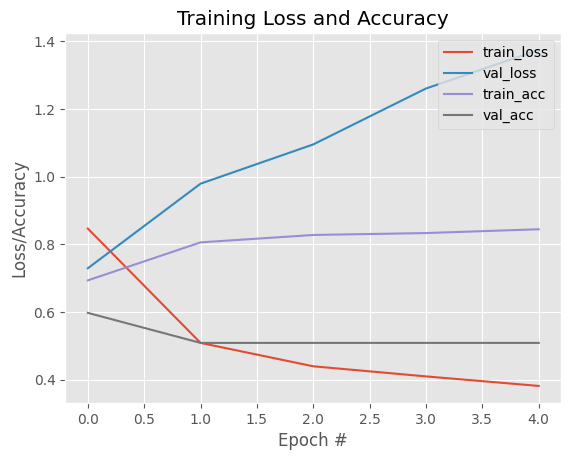

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

# Initial parameters
epochs = 5
lr = 1e-3
batch_size = 64
img_dims = (96,96,3)

data = []
labels = []

# Load image files from the dataset
image_files = [f for f in glob.glob(r"C:\Users\saksh\Face_Reco\Gender-Detection\gender_dataset_face" + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

# Converting images to arrays and labeling the categories
for img in image_files:
    image = cv2.imread(img)
    image = cv2.resize(image, (img_dims[0], img_dims[1]))
    image = img_to_array(image)
    data.append(image)
    label = img.split(os.path.sep)[-2]  # Extract folder name for label (woman or man)
    label = 1 if label == "woman" else 0
    labels.append([label])  # [[1], [0], [0], ...]

# Pre-processing
data = np.array(data, dtype="float") / 255.0  # Normalize image data
labels = np.array(labels)

# Split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)
trainY = to_categorical(trainY, num_classes=2)  # Convert labels to one-hot encoding
testY = to_categorical(testY, num_classes=2)

# Augmenting dataset
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")

# Define model
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1

    model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model

# Build model
model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2], classes=2)

# Create a learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps=epochs,
    decay_rate=0.9,
    staircase=True
)

# Compile the model with the learning rate schedule
opt = Adam(learning_rate=lr_schedule)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the model
H = model.fit(aug.flow(trainX, trainY, batch_size=batch_size), validation_data=(testX, testY), steps_per_epoch=len(trainX) // batch_size, epochs=epochs, verbose=1)

# Ensure directory exists for saving the model
os.makedirs('saved_models', exist_ok=True)

# Save the model to disk
model.save('saved_models/gender_detection.model')

# Plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

# Save plot to disk
plt.savefig('saved_models/plot.png')
